# Performing a basic analysis

* **Prerequisites**:  Users of this notebook should have a basic understanding of:
    * How to run a [Jupyter notebook](01_Jupyter_notebooks.ipynb)
    * Inspecting available [Products and measurements](02_Products_and_measurements.ipynb)
    * How to [load data](03_Loading_data.ipynb)
    * How to [plot loaded data](04_Plotting.ipynb)

## Background
To understand the world around us, it's important to combine the key steps of loading, visualising, analysing, and interpreting satellite data.
To perform an analysis, we begin with a question and use these steps to reach an answer.

## Description
This notebook demonstrates how to conduct a basic analysis with the Open Data Cube.
It will combine many of the steps that have been covered in the other beginner's notebooks.

In this notebook, the analysis question is _"How is the health of vegetation changing over time in a given area?"_

This could be related to a number of broader questions: 

* What is the effect of a new land use practice on a field of crops?
* How has a patch of forest changed after a fire? 
* How does proximity to water affect vegetation throughout the year?

For this notebook, the analysis question will be kept simple, without much real-world context. 
For more examples of notebooks that demonstrate how to use the data cube to answer specific analysis questions, see the notebooks in the "Real world examples" folder. 

Topics covered in this notebook include:

1. Choosing a study area.
2. Loading data for the study area.
3. Plotting the chosen data and exploring how it changes with time.
4. Calculating a measure of vegetation health from the loaded data.
5. Exporting the data for further analysis.

***

## Getting started
To run this introduction to plotting data loaded from the datacube, run all the cells in the notebook starting with the "Load packages" cell. For help with running notebook cells, refer back to the [Jupyter Notebooks notebook](01_Jupyter_notebooks.ipynb). 

### Load packages
The cell below imports Python packages that are used for the analysis.
The first command is `%matplotlib inline`, which ensures figures plot correctly in the Jupyter notebook.
The following commands import various functionality: 

* `sys` provides access to helpful support functions in the `deafrica_plotting` module. 
* `datacube` provides the ability to query and load data.
* `matplotlib` provides the ability to format and manipulate plots.

In [2]:
%matplotlib inline

import sys
import datacube
import matplotlib.pyplot as plt
from datacube.utils.cog import write_cog
from datacube.helpers import write_geotiff
import numpy as np
import pandas as pd
import xarray as xr

sys.path.append("../Scripts")
from deafrica_plotting import display_map, rgb

### Connect to the datacube
The next step is to connect to the datacube database.
The resulting `dc` datacube object can then be used to load data.
The `app` parameter is a unique name used to identify the notebook that does not have any effect on the analysis.

In [3]:
dc = datacube.Datacube(app="05_Basic_analysis")

## Step 1: Choose a study area

When working with the Open Data Cube, it's important to load only as much data as needed.
This helps keep an analysis running quickly and avoids the notebook crashing due to insufficient memory.

One way to set the study area is to set a central latitude and longitude coordinate pair, `(central_lat, central_lon)`, then specify how many degrees to include either side of the central latitude and longitude, known as the `buffer`.
Together, these parameters specify a square study area, as shown below:

<img src="../images/latlong_buffer.png" width="250" height="250">

### Location
Below, we have set the study area covering a forestry area near Santiago.
To load a different area, you can provide your own `central_lat` and `central_lon` values.
One way to source these is to Google a location, or click directly on the map in [Google Maps](https://goo.gl/maps/YvJv5UXi8y6v2hhZ9).

> **Note**: If you change the study area latitude and longitude, you'll need to re-run all of the cells after to apply that change to the whole analysis.

### Buffer
Feel free to experiment with the `buffer` value to load different sized areas.
We recommend that you keep the `buffer` relatively small, no higher than `buffer=0.1` degrees.
This will help keep the loading times reasonable and prevent the notebook from crashing.

> **Extension**: Can you modify the code to use a different `buffer` value for latitude and longitude? 

> *Hint*: You may want two variables, `buffer_lat` and `buffer_lon` that you can set independently. You'll then need to update the definitions of `study_area_lat` and `study_area_lon` with their corresponding buffer value.

In [6]:
# Set the central latitude and longitude
central_lat = -33.273429
central_lon = -70.138963

# Set the buffer to load around the central coordinates
buffer = 0.45/2

# Compute the bounding box for the study area
study_area_lat = (central_lat - buffer, central_lat + buffer)
study_area_lon = (central_lon - buffer, central_lon + buffer)

After choosing the study area, it can be useful to visualise it on an interactive map.
This provides a sense of scale.
> **Note**: The interactive map also returns latitude and longitude values when clicked.
You can use this to generate new latitude and longitude values to try without leaving the notebook.

In [8]:
display_map(x=study_area_lon, y=study_area_lat)

## Step 2: Loading data

When asking analysis questions about vegetation, it's useful to work with optical imagery, such as Sentinel-2 or Landsat.
The Landsat satellites (5, 7, and 8) have 30 metre resolution and go back decades.  In this analysis we will load data using Landsat 8.

The code below sets up the required information to load the data.

In [4]:
# Set the data source - s2a corresponds to Sentinel-2A
set_product = "usgs_espa_ls8c1_toa"


# Set the date range to load data over
set_time = ("2013-01-01", "2020-10-1")

# Set the measurements/bands to load
# For this analysis, we'll load the red, green, blue and near-infrared bands
set_measurements = [
    "pixel_qa",
    "nir",
    "swir1",
]

# Set the coordinate reference system and output resolution
set_crs = 'EPSG:32719'

set_resolution = (-30, 30)

After setting all of the necessary parameters, the `dc.load()` command is used to load the data:

In [7]:
dataset = dc.load(
    product=set_product,
    x=study_area_lon,
    y=study_area_lat,
    time=set_time,
    measurements=set_measurements,
    output_crs=set_crs,
    resolution=set_resolution,
    dask_chunks={"time": 1}
)

Following the load step, printing the `dataset` object will give you insight into all of the data that was loaded.
Do this by running the next cell.

There's a lot of information to unpack, which is represented by the following aspects of the data:
- `Dimensions`: the names of data dimensions, frequently `time`, `x` and `y`, and number of entries in each
- `Coordinates`: the coordinate values for each point in the data cube
- `Data variables`: the observations loaded, frequently different spectral bands from a satellite
- `Attributes`: any useful information for the data, such as the `crs` (coordinate reference system)

In [8]:
print(dataset)

<xarray.Dataset>
Dimensions:      (time: 170, x: 1416, y: 1679)
Coordinates:
  * time         (time) datetime64[ns] 2013-04-02T14:31:10.563911 ... 2020-08...
  * y            (y) float64 6.343e+06 6.343e+06 ... 6.293e+06 6.293e+06
  * x            (x) float64 3.726e+05 3.727e+05 ... 4.151e+05 4.151e+05
    spatial_ref  int32 32719
Data variables:
    pixel_qa     (time, y, x) uint16 dask.array<chunksize=(1, 1679, 1416), meta=np.ndarray>
    nir          (time, y, x) int16 dask.array<chunksize=(1, 1679, 1416), meta=np.ndarray>
    swir1        (time, y, x) int16 dask.array<chunksize=(1, 1679, 1416), meta=np.ndarray>
Attributes:
    crs:           EPSG:32719
    grid_mapping:  spatial_ref


## Step 3: Plotting data

After loading the data, it is useful to view it to understand the resolution, which observations are impacted by cloud cover, and whether there are any obvious differences between time steps.

We use the `rgb()` function to plot the data loaded in the previous step.
The `rgb()` function maps three data variables/measurements from the loaded dataset to the red, green and blue channels that are used to make a three-colour image.
There are several parameters you can experiment with:

* `time_step=n`\
This sets the time step you want to view. 
`n` can be any number from `0` to one fewer than the number of time steps you loaded. 
The number of time steps loaded is given in the print-out of the data, under the `Dimensions` heading. 
As an example, if under `Dimensions:` you see `time: 6`, then there are 6 time steps, and `time_step` can be any number between `0` and `5`.

* `bands=[red_channel, green_channel, blue_channel]`\
This sets the measurements that you want to use to make the image.
Any measurements can be mapped to the three channels, and different combinations highlight different features.
Two common combinations are
    * true colour: 
    `bands = ["red", "green", "blue"]`
    * false colour: `bands = ["nir", "red", "green"]`
    
For more detail about customising plots, see the [Introduction to plotting](04_Plotting.ipynb) notebook.

> **Extension**: If `time_step` is set to an array of values, e.g. `time_step=[time_1, time_2]`, it will plot all provided time steps.
See if you can modify the code to plot the first and last images.
If you do, what changes do you notice?

> *Hint*: To get the last image, you can use a time step value of `-1`

In [9]:
# Set the time step to view
time_step = 0
time_index = 4

In [10]:
dataset.swir1

<xarray.DataArray 'swir1' (time: 170, y: 1679, x: 1416)>
dask.array<dc_load_swir1, shape=(170, 1679, 1416), dtype=int16, chunksize=(1, 1679, 1416), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 2013-04-02T14:31:10.563911 ... 2020-08...
  * y            (y) float64 6.343e+06 6.343e+06 ... 6.293e+06 6.293e+06
  * x            (x) float64 3.726e+05 3.727e+05 ... 4.151e+05 4.151e+05
    spatial_ref  int32 32719
Attributes:
    units:         reflectance
    nodata:        -9999
    crs:           EPSG:32719
    grid_mapping:  spatial_ref

## Step 4: Calculate NIR SWIR 


$$
\begin{aligned}
\text{NDGI} & = \frac{(\text{Green} - \text{NIR})}{(\text{NIR} + \text{Green})} \\
\end{aligned}
$$


In [11]:
# Calculate NDSI, NDGI & NDSII
swir1 = dataset.swir1.where(dataset.swir1 != 0, other=1e-8) 

dataset['nir_swir'] = dataset.nir / swir1

# El umbral de los valores del sir_swir va desde 4 

After calculating the NDVI values, it is possible to plot them by adding the `.plot()` method to `ndvi` (the variable that the values are stored in).
The code below will plot a single image, based on the time selected with the `ndvi_time_step` variable.
Try changing this value to plot the NDVI map at different time steps.
Do you notice any differences?

> **Extension 1**: Sometimes, it is valuable to change the colour scale to something that helps with intuitively understanding the image.
For example, the "viridis" colour map shows high values in greens/yellows (mapping to vegetation), and low values in blue (mapping to water).
Try modifying the `.plot(cmap="RdYlGn")` command below to use `cmap="viridis"` instead.

> **Extension 2**: Below, a single time step is selected using the `.isel()` method.
It is possible to plot all time steps by removing the `.isel()` method, and modifying the `.plot()` method to be `.plot(col=time, col_wrap=3)`.
Plotting all of the time steps at once may make it easier to notice differences in vegetation over time.

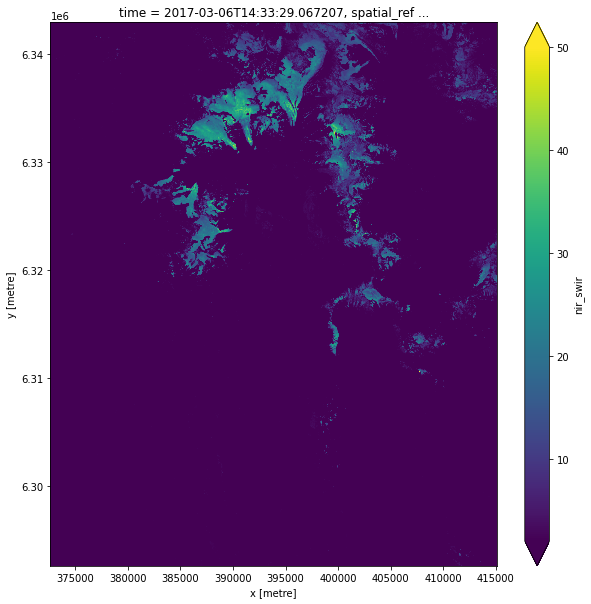

In [12]:
# Set the time step to view
ndgi_time_step = 90

plt.figure(figsize=(10, 10))
dataset['nir_swir'].isel(time=ndgi_time_step).plot(vmin = 2, vmax = 50)
plt.show()




In [50]:
icesnow = dataset['pixel_qa']
icesnow.attrs['flags_definition'] = 1
icesnow = icesnow.drop('time')
print(icesnow)

file_netcdf_c = "ls8_toa_2013_2020_icesnow.nc"
icesnow.to_netcdf(file_netcdf_c)


<xarray.DataArray 'pixel_qa' (time: 170, y: 1679, x: 1416)>
dask.array<dc_load_pixel_qa, shape=(170, 1679, 1416), dtype=uint16, chunksize=(1, 1679, 1416), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 6.343e+06 6.343e+06 ... 6.293e+06 6.293e+06
  * x            (x) float64 3.726e+05 3.727e+05 ... 4.151e+05 4.151e+05
    spatial_ref  int32 32719
Dimensions without coordinates: time
Attributes:
    units:             bit_index
    nodata:            1
    flags_definition:  1
    crs:               EPSG:32719
    grid_mapping:      spatial_ref


## Step 5: Charts
It is possible to create time-series charts as well as displaying images. To do this, firstly the data needs to be converted to a format that can be shown on a single chart. This means that the the multi-dimensional data needs to be converted to only two dimensions. This can be achieved in two simple ways:
- by selecting a single pixel, or 
- summarising of the data such as calculating the average, minimum or maximum pixel values for each scene.

To select a single pixel, you can either use the `.sel()` method with true x and y values and choosing the nearest pixel (e.g. by looking at the image above):

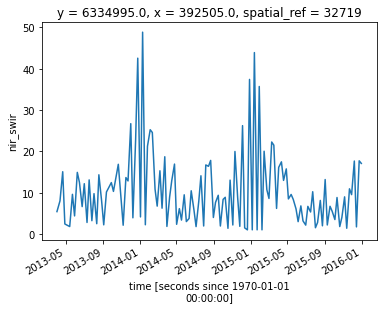

In [197]:
dataset['nir_swir'].sel(x=392500, y=6335000, method='nearest').plot()

Alternatively, you can also use x and y index values and the `isel()` method:

In [ ]:
dataset['nir_swir'].isel(x=[200], y=[200]).plot()

You can also choose to plot a slice through the image by specifying just one dimension:

In [ ]:
dataset['nir_swir'].isel(x=[200]).plot()

Many other chart options are possible using the Matplotlib or similar libraries

## Step 6: Exporting data

Sometimes, you will want to analyse satellite imagery in a GIS program, such as QGIS.
The `write_geotiff()` command from the Open Data Cube library allows loaded data to be exported to GeoTIFF, a commonly used file format for geospatial data. This step is saving a special type of GeoTIFF called a Cloud Optimised GeoTIFF or [COG](https://www.cogeo.org/). This is a modified version of a GeoTIFF which is optimised to work in cloud computing environments. This file will still load in GIS programs.
> **Note**: the saved file will appear in the same directory as this notebook, and it can be downloaded from here for later use.

In [ ]:
#data = dataset.drop('pixel_qa')
tiempo = dataset.time.to_dataframe().to_csv('time_2013_2020.csv')
data = dataset.drop('time')
file_netcdf = "ls8_toa_2013_2020_glaciar.nc"
data.to_netcdf(file_netcdf)


In [ ]:
print(datacube.__version__)